In [41]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.offline as py
import matplotlib.pyplot as plt
py.init_notebook_mode()
%matplotlib inline
plt.style.use('fivethirtyeight')

Load the data

In [42]:
input_file = 'data/processed_data.csv'

Read the CSV file

In [43]:
df = pd.read_csv(input_file)

In [44]:
df.head()

DateTime  Year  Month  Date  Time  Minute  Temperature  \
0  2008-01-08 00:01:00  2008      1     8     0       1         14.7   
1  2008-01-08 10:01:00  2008      1     8     1       1         15.0   
2  2008-01-08 20:01:00  2008      1     8     2       1         14.9   
3  2008-01-08 03:01:00  2008      1     8     3       1         14.9   
4  2008-01-08 04:01:00  2008      1     8     4       1         15.0   

   Previous Day Average  Two Days Before Average  Three Days Before Average  \
0               16.0375                   13.475                  11.404167   
1               16.0375                   13.475                  11.404167   
2               16.0375                   13.475                  11.404167   
3               16.0375                   13.475                  11.404167   
4               16.0375                   13.475                  11.404167   

   Last 7 Days Average  Previous Day Wind Speed  Previous Day Rainfall  
0            29.403571                18.708333                    0.0  
1            29.403571                18.708333                    0.0  
2            29.403571                18.708333                    0.0  
3            29.403571                18.708333                    0.0  
4            29.403571                18.708333                    0.0

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137787 entries, 0 to 137786
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   DateTime                   137787 non-null  object 
 1   Year                       137787 non-null  int64  
 2   Month                      137787 non-null  int64  
 3   Date                       137787 non-null  int64  
 4   Time                       137787 non-null  int64  
 5   Minute                     137787 non-null  int64  
 6   Temperature                137787 non-null  float64
 7   Previous Day Average       137787 non-null  float64
 8   Two Days Before Average    137787 non-null  float64
 9   Three Days Before Average  137787 non-null  float64
 10  Last 7 Days Average        137787 non-null  float64
 11  Previous Day Wind Speed    135041 non-null  float64
 12  Previous Day Rainfall      135041 non-null  float64
dtypes: float64(7), int64(5), obje

Rename the columns for better readability

In [46]:
df.columns = ['DateTime', 'Year', 'Month', 'Date', 'Time', 'Minute', 'Temperature', 'Previous Day Average', 'Two Days Before Average', 'Three Days Before average', 'Last 7 Days Average', 'Previous Day Wind Speed', 'Previous Day Rainfall']

Convert the 'Date' and 'Time' columns to integers

In [47]:
df['Date'] = df['Date'].astype(int)
df['Time'] = df['Time'].astype(int)

Fill leading zeros for the 'Time' column

In [48]:
df['Time'] = df['Time'].apply(lambda x: str(x).zfill(4))

Combine the 'Date' and 'Time' columns into a single 'DateTime' column<br>
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + df['Time'], format='%Y%m%d%H%M')

Remove rows with a specific value (e.g., 32767) in 'Temperature' column

In [49]:
df = df[df['Temperature'] != 32767]

Calculate the mean and standard deviation of Y

In [50]:
threshold = 5
mean_Y = np.mean(df['Temperature'])
std_Y = np.std(df['Temperature'])

Define the range of acceptable Y values

In [51]:
lower_bound = mean_Y - threshold * std_Y
upper_bound = mean_Y + threshold * std_Y

Filter out rows with Y values outside the acceptable range

In [52]:
df = df[(df['Temperature'] >= lower_bound) & (df['Temperature'] <= upper_bound)]

Divide the 'Temperature' column by 10 to convert it to degrees Celsius

In [53]:
# df['Temperature'] = df['Temperature'] / 10

Prepare the data for Prophet

In [54]:
df['DateTime'] = pd.to_datetime(df['DateTime'], format="%Y-%m-%d %H:%M:%S")
prophet_df = df.copy()
prophet_df.rename(columns={'DateTime': 'ds', 'Temperature': 'y'}, inplace=True)
prophet_df.dropna(inplace=True)
# prophet_df = prophet_df[prophet_df['Month'] == 7]

In [55]:
prophet_df.head()

ds  Year  Month  Date  Time  Minute     y  \
0 2008-01-08 00:01:00  2008      1     8  0000       1  14.7   
1 2008-01-08 10:01:00  2008      1     8  0001       1  15.0   
2 2008-01-08 20:01:00  2008      1     8  0002       1  14.9   
3 2008-01-08 03:01:00  2008      1     8  0003       1  14.9   
4 2008-01-08 04:01:00  2008      1     8  0004       1  15.0   

   Previous Day Average  Two Days Before Average  Three Days Before average  \
0               16.0375                   13.475                  11.404167   
1               16.0375                   13.475                  11.404167   
2               16.0375                   13.475                  11.404167   
3               16.0375                   13.475                  11.404167   
4               16.0375                   13.475                  11.404167   

   Last 7 Days Average  Previous Day Wind Speed  Previous Day Rainfall  
0            29.403571                18.708333                    0.0  
1            29.403571                18.708333                    0.0  
2            29.403571                18.708333                    0.0  
3            29.403571                18.708333                    0.0  
4            29.403571                18.708333                    0.0

In [56]:
prophet_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133598 entries, 0 to 135040
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ds                         133598 non-null  datetime64[ns]
 1   Year                       133598 non-null  int64         
 2   Month                      133598 non-null  int64         
 3   Date                       133598 non-null  int64         
 4   Time                       133598 non-null  object        
 5   Minute                     133598 non-null  int64         
 6   y                          133598 non-null  float64       
 7   Previous Day Average       133598 non-null  float64       
 8   Two Days Before Average    133598 non-null  float64       
 9   Three Days Before average  133598 non-null  float64       
 10  Last 7 Days Average        133598 non-null  float64       
 11  Previous Day Wind Speed    133598 non-null  float64      

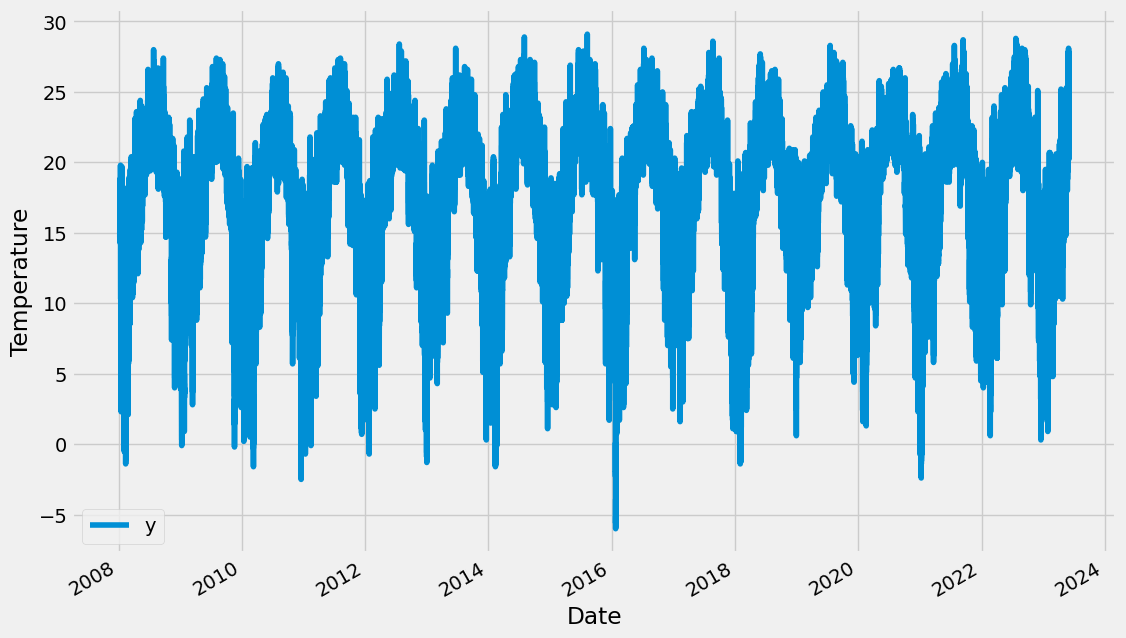

In [57]:
ax = prophet_df[["ds", "y"]].set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Temperature')
ax.set_xlabel('Date')

plt.show()

Split the dataset into training and validation sets (80% for training, 20% for validation)

In [58]:
train_df = prophet_df # .loc[prophet_df['ds'] < '2022-07-01']
validation_df = prophet_df.loc[(prophet_df['ds'] >= '2022-07-01') & (prophet_df['ds'] < '2022-08-01')]

In [59]:
validation_df.reset_index(drop=True, inplace=True)

Initialize and fit the Prophet model

In [60]:
model = Prophet(
    interval_width=0.95,  # Increase the interval width to capture more uncertainty
    n_changepoints=25,  # Increase the number of changepoints for more flexibility
    yearly_seasonality=True,  # Keep yearly seasonality
    weekly_seasonality=False,  # Add weekly seasonality
    daily_seasonality=True,  # Add daily seasonality
    changepoint_prior_scale=2,  # Reduce the changepoint prior scale for smoother trends
    seasonality_mode='additive',  # Use multiplicative seasonality for better handling of varying scales
    # changepoint_range=0.8,  # Restrict changepoints to the first 80% of the data
    seasonality_prior_scale=1,
    # growth='logistic'
)
model.add_regressor('Previous Day Average')
model.add_regressor('Two Days Before Average')
model.add_regressor('Three Days Before average')
model.add_regressor('Last 7 Days Average')
model.add_regressor('Previous Day Wind Speed')
model.add_regressor('Previous Day Rainfall')
model.add_regressor('Time')
model.add_seasonality(name='daily', period=1, fourier_order=100)
# model.add_seasonality(name='hourly', period=1/24, fourier_order=100)
model.fit(train_df)

19:10:19 - cmdstanpy - INFO - Chain [1] start processing
19:11:22 - cmdstanpy - INFO - Chain [1] done processing


Make predictions for the validation dataset

In [61]:
validation_predictions = model.predict(validation_df)

Calculate the mean squared error (MSE) for the validation set

In [62]:
mse = np.mean((validation_df['y'] - validation_predictions['yhat']) ** 2)
print("Mean Squared Error (MSE) for the validation set:", mse)
mas = np.mean(abs(validation_df['y'] - validation_predictions['yhat']))
print("Mean Absolute Error (MAE) for the validation set:", mas)
# accuracy = 

Mean Squared Error (MSE) for the validation set: 2.6644493019459086
Mean Absolute Error (MAE) for the validation set: 1.2037183154413373


Generate future date times for prediction

In [63]:
future_dates = pd.date_range(start='2022-07-01', periods=30000, freq='1min')  # Adjust the start date and number of periods as needed

Create a dataframe with the future dates

In [64]:
future_df =  pd.DataFrame({'ds': future_dates})

Use the trained model to make predictions

In [65]:
predictions = model.predict(validation_df)
predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds       yhat  yhat_lower  yhat_upper
0 2022-07-01 00:01:00  21.671560   16.386177   26.928889
1 2022-07-01 03:01:00  21.651303   16.938311   27.081240
2 2022-07-01 04:01:00  21.490392   16.224643   26.516248
3 2022-07-01 05:01:00  21.383353   16.226012   26.267958
4 2022-07-01 06:01:00  21.391850   15.911473   26.233742

In [66]:
all_predictions = model.predict(prophet_df.dropna(inplace=True))

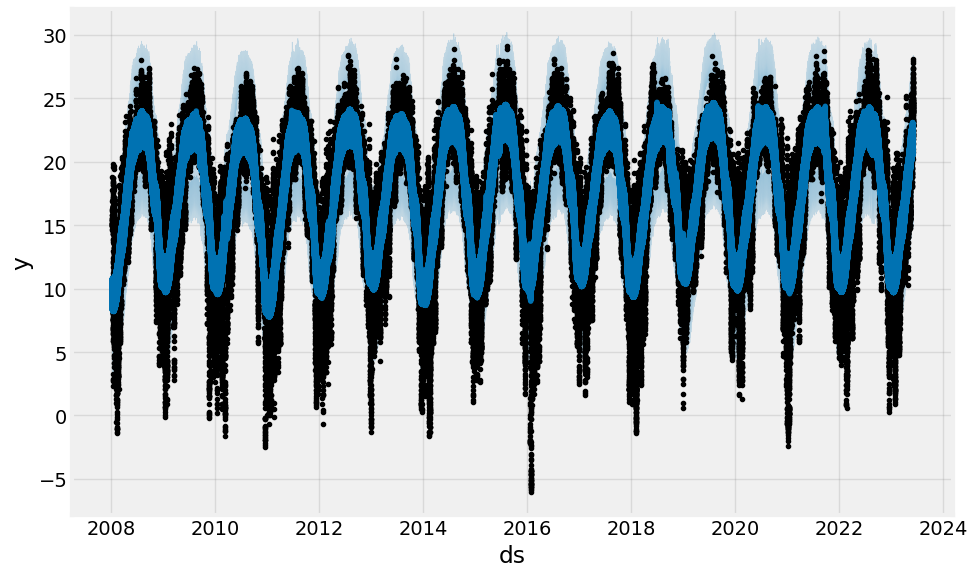

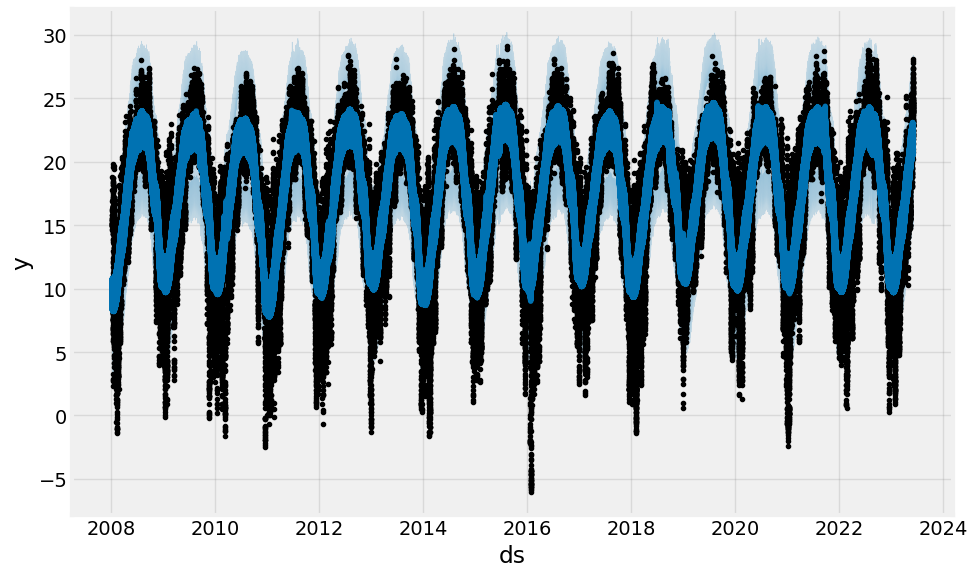

In [67]:
model.plot(all_predictions, uncertainty=True)

Print the predicted temperatures for the future dates

In [68]:
print(predictions[['ds', 'yhat']].tail(10))  # Adjust the number of rows to display as needed

                     ds       yhat
725 2022-07-31 15:01:00  24.161967
726 2022-07-31 16:01:00  23.800047
727 2022-07-31 17:01:00  23.362967
728 2022-07-31 18:01:00  22.969374
729 2022-07-31 19:01:00  22.677481
730 2022-07-31 20:01:00  22.494143
731 2022-07-31 20:01:00  22.039573
732 2022-07-31 21:01:00  22.412796
733 2022-07-31 22:01:00  22.432808
734 2022-07-31 23:01:00  22.541986


Print the actual and predicted temperatures for the future dates

In [69]:
# actual_values = df.loc[df['DateTime'].isin(future_dates)]
# predicted_values = predictions.loc[predictions['ds'].isin(actual_values['DateTime'])]['yhat'].values
# comparison_df = pd.DataFrame({'DateTime': actual_values['DateTime'].values, 'Actual': actual_values["Temperature"].values, 'Predicted': predicted_values})
# print(comparison_df)

Calculate accuracy (optional, depending on the desired accuracy metric)

In [70]:
# accuracy = np.mean(np.abs(actual_values['Temperature'].values - predicted_values) / actual_values['Temperature'].values)
# print("Accuracy:", (1 - accuracy) * 100, "%")

Visualize the actual vs. predicted temperatures for the validation set

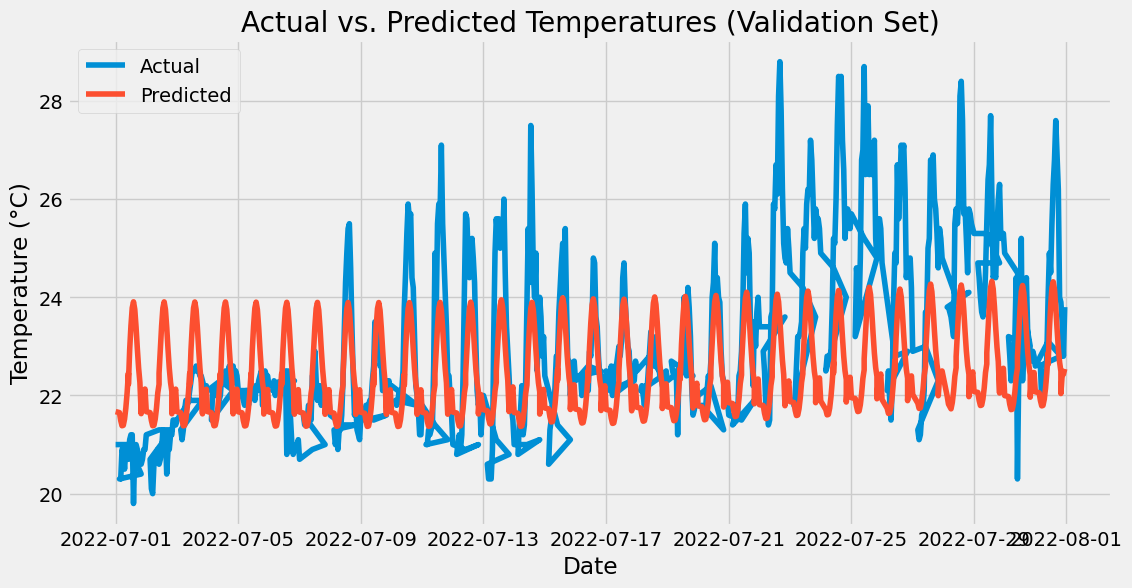

In [71]:
plt.figure(figsize=(12, 6))
plt.plot(validation_df['ds'], validation_df['y'], label='Actual')
plt.plot(validation_predictions['ds'], validation_predictions['yhat'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs. Predicted Temperatures (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()

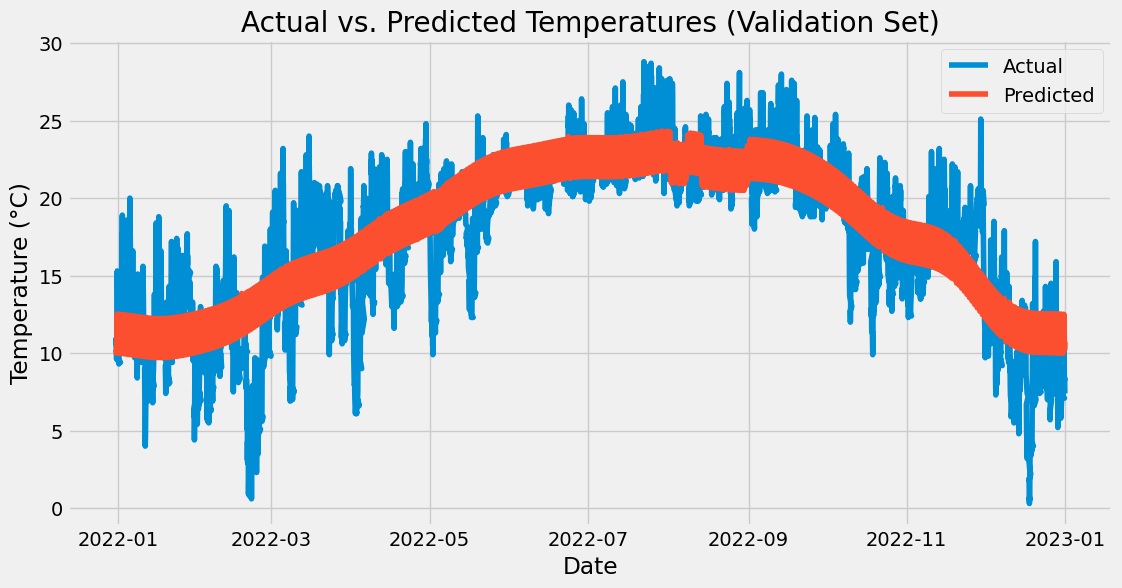

In [72]:
plt.figure(figsize=(12, 6))
# condition = '2021-12-31' < prophet_df['ds'] < '2023-01-01'
plt.plot(prophet_df[(prophet_df['ds'] < '2023-01-01') & (prophet_df['ds'] > '2021-12-31')]['ds'], prophet_df[(prophet_df['ds'] < '2023-01-01') & (prophet_df['ds'] > '2021-12-31')]['y'], label='Actual')
plt.plot(all_predictions[(all_predictions['ds'] < '2023-01-01') & (all_predictions['ds'] > '2021-12-31')]['ds'], all_predictions[(all_predictions['ds'] < '2023-01-01') & (all_predictions['ds'] > '2021-12-31')]['yhat'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs. Predicted Temperatures (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()

In [73]:
import pickle

# Assuming you have trained the Prophet model and stored it in a variable called 'model'
with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(model, f)
